# 2D inversion of two spheres in a half space using Bayesian inversion

In [1]:
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as DCUtils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
from scipy.sparse import diags
# from PGI_DC_example_Utils import plot_pseudoSection, getCylinderPoints

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


# create the mesh

In [2]:
# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(500.)
ln_sigc = -np.log(90.)
ln_sigr = -np.log(50.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

mtrue = ln_sigback * np.ones(mesh.nC) # + norm(noisemean, noisevar).rvs(mesh.nC)
mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph])  # + \
    # norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) # + \
    # norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

# sphere smaller but higher conductivity
csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph])


mtrue = utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = discretize.utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

-15.0 15 -15.0 0.0


/tmp/ipykernel_542376/2403389077.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(mtrue_plotting, ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
/home/johnathan/anaconda3/envs/jenv/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


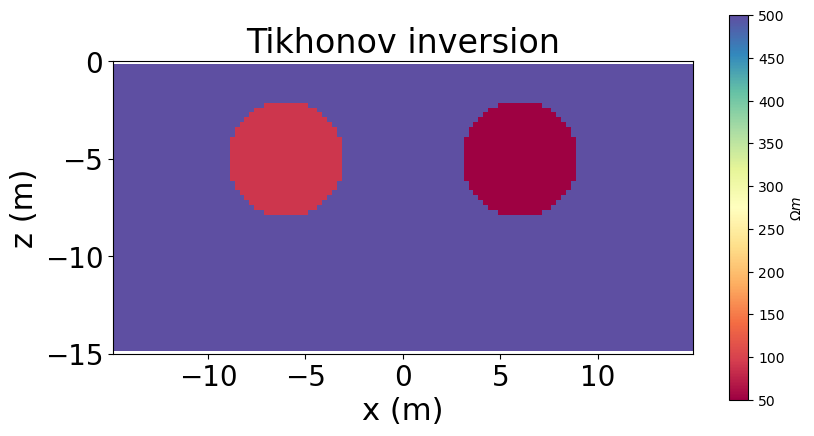

In [3]:
mtrue_plotting = 1 / np.exp(mtrue[actcore])
clim = [mtrue_plotting.min(), mtrue_plotting.max()]

fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mtrue_plotting, ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0], label=r'$\Omega m$')
plt.show()

### Create a pole-dipole dipole-pole dc survey

In [4]:
# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = DCUtils.generate_dcip_survey(
    endl, survey_type="pole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = DCUtils.generate_dcip_survey(
    endl, survey_type="pole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)
survey3 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-pole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey4 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-pole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = dc.Survey(survey1.source_list + survey2.source_list + survey3.source_list + survey4.source_list)
survey_rto = dc.Survey(survey1.source_list + survey2.source_list + survey3.source_list + survey4.source_list)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(1e8)
)
mapping = expmap * mapactive

# forward simulation
fwd_simulation = dc.Simulation2DNodal(
    mesh,
    survey,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)


std = 0.02
# survey.dpred(mtrue[actcore])
dpred = fwd_simulation.make_synthetic_data(mtrue[actcore], relative_error=std, force=True)
survey.eps = 1e-4
survey.dobs = dpred.dobs
std = 0.02 * np.abs(dpred.dobs)

simulation = dc.Simulation2DNodal(
    mesh,
    survey,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)

m0 = -np.log(np.median((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))) * np.ones(mapping.nP)

/home/johnathan/Documents/git/simpeg/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/johnathan/Documents/git/simpeg/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


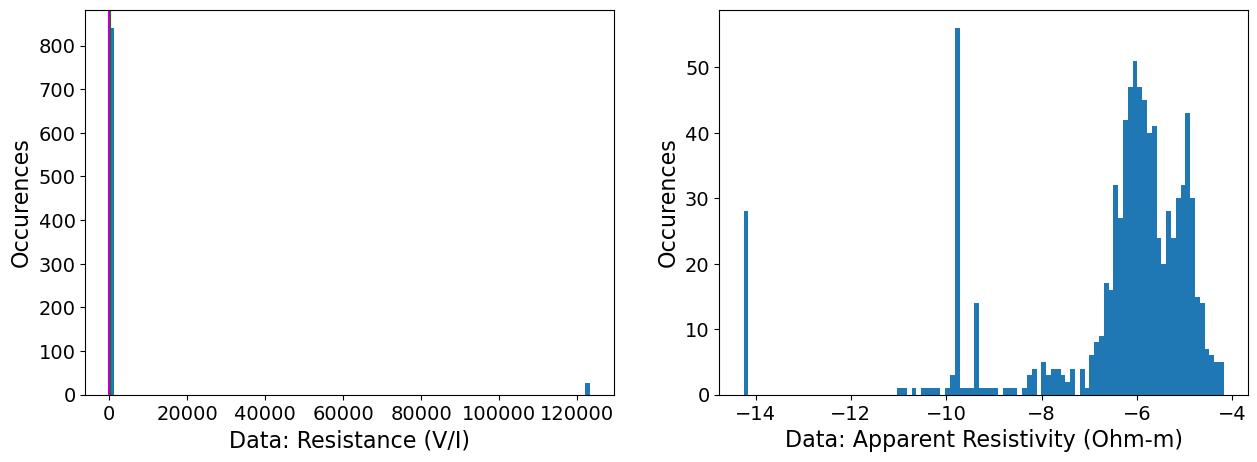

In [5]:
# Plot the histogram of the data
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(np.abs(dpred.dobs), 100)
# ax[1].hist(DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs), 100)
ax[1].hist(-np.log(((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))), 100)
ax[0].axvline(x = np.percentile(DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs), 5), color = 'g', label = 'axvline - full height')
ax[0].axvline(x = 1e-4, color = 'm', label = 'axvline - full height')
# hist, edges = np.histogram(-np.log(((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))),bins=50, density=False)
# hist, edges = np.histogram(dpred.dobs,bins=50, density=False)
# ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",color='#8172B3');
# ax.plot((1./np.exp(-4.72760309)*np.ones(2)),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(115,30,'Starting half-space\nwhen no mean\npetrophysical information\nis available',fontsize=16)
# ax.plot(100.*np.ones(2),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(98,20,'True\nbackground\nmean',fontsize=16,ha='right')
# ax.grid(True,which='both')
# ax.grid(True,which="major",ls="-")

ax[0].set_xlabel('Data: Resistance (V/I)',fontsize=16)
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel('Occurences',fontsize=16)

ax[1].set_xlabel('Data: Apparent Resistivity (Ohm-m)',fontsize=16)
ax[1].tick_params(labelsize=14)
ax[1].set_ylabel('Occurences',fontsize=16)

plt.show()

# Lets look at some perturbed data

In [6]:

model_perturb = 1e5
std = 0.01 * np.abs(dpred.dobs)
# Wm = np.sqrt(beta_perturb) * np.eye(mesh.nC)

n_model_samples = meshCore.nC

# coefficient matrix
zero_means_ = np.zeros(1)
identity_matrix_ = np.eye(1)

Wm = np.sqrt(model_perturb) * diags(np.ones(n_model_samples))

# print('creating s')
s = np.random.multivariate_normal(zero_means_, identity_matrix_, size=n_model_samples)

# perturbed_mod = np.linalg.solve(Wm, s3)
ainv = Solver(Wm)

perturbed_mod = ainv * s

perturbed_mod = -np.log(1 / np.exp(m0) + perturbed_mod)



/home/johnathan/anaconda3/envs/jenv/lib/python3.11/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/home/johnathan/anaconda3/envs/jenv/lib/python3.11/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


NameError: name 'data_object' is not defined

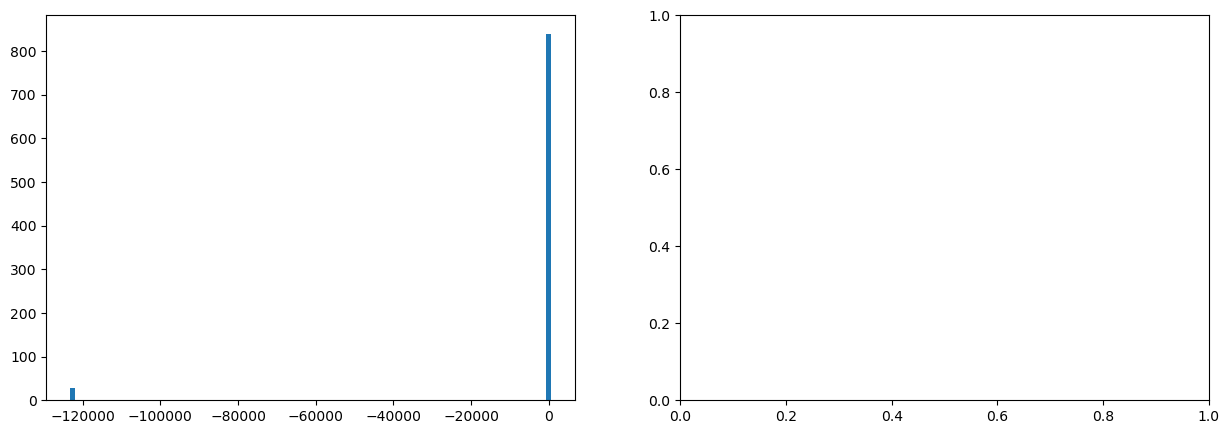

In [7]:
# Plot the histogram of the data
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(dpred.dobs, 100)
ax[0].hist(data_object.dobs, 100, alpha=0.4)
ax[1].hist(DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs), 100)
ax[1].hist(DCUtils.apparent_resistivity_from_voltage(survey, data_object.dobs), 100, alpha=0.4)
# ax[1].set_xlim([-10000, 1e5])
ax[1].hist(-np.log(((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))), 100)
ax[0].axvline(x = 1e-2, color = 'm', label = 'axvline - full height')
# hist, edges = np.histogram(-np.log(((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))),bins=50, density=False)
# hist, edges = np.histogram(dpred.dobs,bins=50, density=False)
# ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",color='#8172B3');
# ax.plot((1./np.exp(-4.72760309)*np.ones(2)),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(115,30,'Starting half-space\nwhen no mean\npetrophysical information\nis available',fontsize=16)
# ax.plot(100.*np.ones(2),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(98,20,'True\nbackground\nmean',fontsize=16,ha='right')
# ax.grid(True,which='both')
# ax.grid(True,which="major",ls="-")

ax[0].set_xlabel('Data: Resistance (V/I)',fontsize=16)
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel('Occurences',fontsize=16)

ax[1].set_xlabel('Data: Apparent Resistivity (Ohm-m)',fontsize=16)
ax[1].tick_params(labelsize=14)
ax[1].set_ylabel('Occurences',fontsize=16)

plt.show()

plt.hist(1/np.exp(m0), 50)
plt.hist(1 / np.exp(perturbed_mod), 50)

plt.show()
print(m0.shape, perturbed_mod.shape)

mtrue_plotting = 1 / np.exp(perturbed_mod)
clim = [mtrue_plotting.min(), mtrue_plotting.max()]

fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mtrue_plotting, ax=ax, clim=[0, 500], pcolorOpts={'cmap':"Spectral"})
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0], label=r'$\Omega m$')
plt.show()

# lets try invert the simulated data

In [8]:
# Data misfit
dmis = data_misfit.L2DataMisfit(data=dpred, simulation=simulation)
# Regularization
regmap = maps.IdentityMap(nP=int(actcore.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

reg = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=regmap,
    reference_model=m0
)
reg.alpha_s = 1/csx**2
reg.alpha_x = 100
reg.alpha_y = 100
reg.alpha_z = 100

# Optimization object
opt = optimization.ProjectedGNCG(maxIter=10, lower=-10, upper=10,
                                 maxIterLS=20, maxIterCG=100, tolCG=1e-5)

opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg,  opt)
invProb.beta = 1e0

# Inversion directives
Target = directives.TargetMisfit()
betaSched = directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
updateSensW = directives.UpdateSensitivityWeights(threshold=1e-2,everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
inv = inversion.BaseInversion(invProb,  directiveList=[ # updateSensW, 
                                                       Target,
                                                       betaSched,
                                                    #    update_Jacobi,
                                                       ])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m0)
print('Inversion took {0} seconds'.format(time.time() - start))

/tmp/ipykernel_470650/1389508402.py:31: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=1e-2,everyIter=False)
/tmp/ipykernel_470650/1389508402.py:31: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=1e-2,everyIter=False)



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.69e+09  1.09e+04  1.69e+09    1.67e+03      0              
   1  5.00e-01  1.69e+09  1.09e+04  1.69e+09    1.67e+03      0              
   2  2.50e-01  1.69e+09  1.09e+04  1.69e+09    1.67e+03      0   Skip BFGS  
   3  1.25e-01  1.69e+09  1.09e+04  1.69e+09    1.67e+03      0   Skip BFGS  
   4  6.25e-02  1.69e+09  1.09e+04  1.69e+09    1.67e+03      0   Skip BFGS  
   5  3.12e-02  1.69e+09  1.09e+04  1.69e+09    1.67e+03      0   Skip BFGS  
   6  1.56e-02  1.69e+09  1.09e+04 

/tmp/ipykernel_470650/2470886562.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(mopt), ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral_r"})


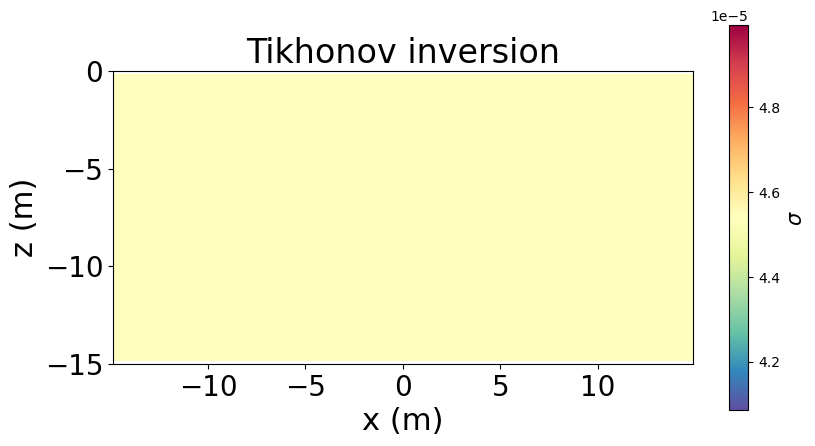

In [9]:
# Plot the recovered model
clim = [np.exp(mopt).min(), np.exp(mopt).max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(np.exp(mopt), ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral_r"})
cd = plt.colorbar(dat[0])
cd.set_label(label=r'$\sigma$', size=15)
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)

# Now try perturbed data

In [7]:
ii = 0
samples_rto = []
while ii < 100:
    Wd = np.diag(std)

    perturbed_data = np.random.multivariate_normal(simulation.survey.dobs, Wd, size=1)[0, :]

    survey_rto.dobs = perturbed_data
    survey_rto.std = np.abs(perturbed_data) * 0.02
    survey_rto.eps = 1e-3

    simulation_rto = dc.Simulation2DNodal(
        mesh,
        survey_rto,
        sigmaMap=mapping,
        storeJ=True,
        solver=Solver
    )

    data_object = data.Data(simulation_rto.survey, dobs=perturbed_data, standard_deviation=survey_rto.std)

    # Data misfit
    survey_rto.eps = 1e-2
    dmis_rto = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_rto)
    dmis_rto.W = 1 / ((0.05 * np.abs(simulation_rto.survey.dobs)) + survey_rto.eps)
    # Regularization
    regmap = maps.IdentityMap(nP=int(actcore.sum()))
    # reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

    # reg_rto = regularization.WeightedLeastSquares(
    #     mesh, 
    #     active_cells=actcore,
    #     mapping=regmap,
    #     reference_model=perturbed_mod
    # )
    reg_rto = regularization.Sparse(
        mesh, alpha_s=1, active_cells=actcore, mapping=regmap, reference_model=perturbed_mod
    )
    reg_rto.norms = [1, 2, 2]
    # reg_rto.alpha_s = 1/csx**2
    # reg_rto.alpha_x = 100
    # reg_rto.alpha_y = 100
    # reg_rto.alpha_z = 100

    # Optimization object
    opt_rto = optimization.ProjectedGNCG(maxIter=10, lower=-10, upper=10,
                                    maxIterLS=20, maxIterCG=100, tolCG=1e-5)

    opt_rto.remember('xc')
    opt_rto.printers += [
        optimization.IterationPrinters.phi_s,
        optimization.IterationPrinters.phi_x,
        optimization.IterationPrinters.phi_y,
        optimization.IterationPrinters.phi_z,
    ]
    opt_rto.print_type = "ubc"

    # Set the inverse problem
    invProb_rto = inverse_problem.BaseInvProblem(dmis_rto,  reg_rto,  opt_rto)
    invProb_rto.beta = 1e0

    # Inversion directives
    Target = directives.TargetMisfit()
    betaSched = directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
    updateSensW = directives.UpdateSensitivityWeights(threshold=1e-2,everyIter=False)
    update_Jacobi = directives.UpdatePreconditioner()
    inv_rto = inversion.BaseInversion(invProb_rto,  directiveList=[ # updateSensW, 
                                                        Target,
                                                        betaSched,
                                                        #    update_Jacobi,
                                                        ])

    import time
    start = time.time()
    # Run the inversion
    mopt = inv_rto.run(m0)
    samples_rto.append(mopt)
    print('Inversion took {0} seconds'.format(time.time() - start))

    ii += 1

ValueError: 'reference_model' must be (10731,), got (7021,)

In [9]:
resulting_samples = np.vstack(samples_rto)
print(resulting_samples.mean(axis=0).shape)
np.save('/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l1p2_100samples.npy', resulting_samples)

(7021,)


/tmp/ipykernel_531771/3996040439.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(resulting_samples).mean(axis=0), clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_531771/3996040439.py:15: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat1 = meshCore.plotImage(np.exp(resulting_samples).std(axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})


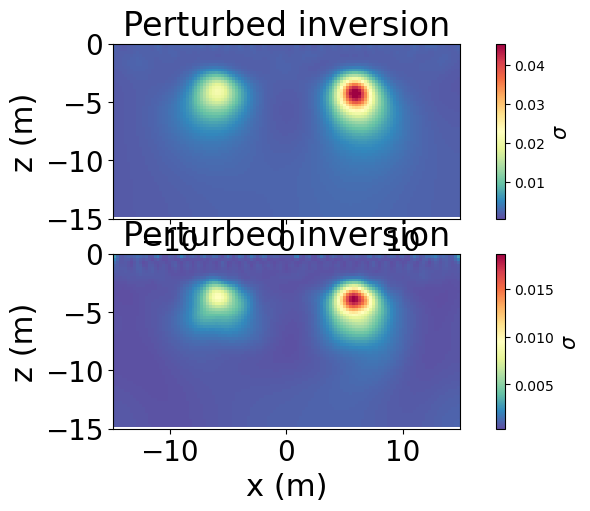

In [10]:
# Plot the recovered model
clim = [np.exp(mopt).min(), np.exp(mopt).max()]
fig, ax = plt.subplots(2,1,figsize=(10,5))
dat = meshCore.plotImage(np.exp(resulting_samples).mean(axis=0), clim=clim, ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})

cd = plt.colorbar(dat[0])
cd.set_label(label=r'$\sigma$', size=15)
ax[0].set_title('Perturbed inversion',fontsize=24)
ax[0].set_aspect('equal')
ax[0].set_ylim([-15,0])
ax[0].set_xlabel('x (m)',fontsize=22)
ax[0].set_ylabel('z (m)',fontsize=22)
ax[0].tick_params(labelsize=20)

dat1 = meshCore.plotImage(np.exp(resulting_samples).std(axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})

cd = plt.colorbar(dat1[0])
cd.set_label(label=r'$\sigma$', size=15)
ax[1].set_title('Perturbed inversion',fontsize=24)
ax[1].set_aspect('equal')
ax[1].set_ylim([-15,0])
ax[1].set_xlabel('x (m)',fontsize=22)
ax[1].set_ylabel('z (m)',fontsize=22)
ax[1].tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)

[-14.75 -14.5  -14.25 -14.   -13.75 -13.5  -13.25 -13.   -12.75 -12.5
 -12.25 -12.   -11.75 -11.5  -11.25 -11.   -10.75 -10.5  -10.25 -10.
  -9.75  -9.5   -9.25  -9.    -8.75  -8.5   -8.25  -8.    -7.75  -7.5
  -7.25  -7.    -6.75  -6.5   -6.25  -6.    -5.75  -5.5   -5.25  -5.
  -4.75  -4.5   -4.25  -4.    -3.75  -3.5   -3.25  -3.    -2.75  -2.5
  -2.25  -2.    -1.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25]


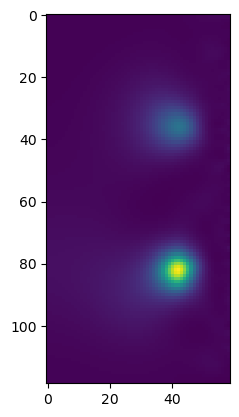

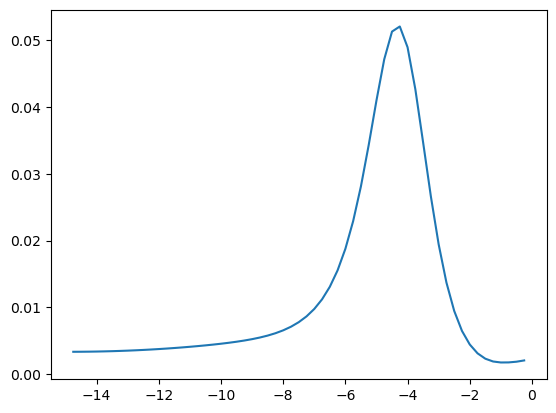

In [29]:
reshape_model = np.exp(resulting_samples).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
print(meshCore.cell_centers_y)

plt.imshow(reshape_model)
plt.show()

plt.plot(meshCore.cell_centers_y, reshape_model[83, :])

In [39]:
plt.hist2d(np.tile(mesh.cell_centers_y, 10), np.array(resulting_samples).reshape(-1),bins=100);
# plt.plot(mesh.cell_centers_y, draws.mean(axis=(0, 1)), '--',label='MCMC mean')
# np.tile(mesh.cell_centers_y, 10).shape
# print(np.array(resulting_samples).reshape(-1).shape, np.tile(mesh.cell_centers_y, 10).shape, re)

(70210,) (730,)


# perturbed data second

In [15]:
perturbed_data2 = np.random.multivariate_normal(simulation.survey.dobs, Wd, size=1)[0, :]
survey_rto2 = survey
survey_rto2.dobs = perturbed_data2
survey_rto2.std = np.abs(perturbed_data2) * 0.02
survey_rto2.eps = 1e-3

simulation_rto2 = dc.Simulation2DNodal(
    mesh,
    survey_rto2,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)

data_object2 = data.Data(simulation_rto2.survey, dobs=perturbed_data2, standard_deviation=survey_rto2.std)

#  Data misfit
survey_rto2.eps = 1e-2
dmis_rto2 = data_misfit.L2DataMisfit(data=data_object2, simulation=simulation_rto2)
dmis_rto2.W = 1 / ((0.5 * simulation_rto2.survey.dobs) + survey_rto2.eps)
# Regularization
regmap = maps.IdentityMap(nP=int(actcore.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

reg_rto2 = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=regmap,
    reference_model=perturbed_mod
)
reg_rto2.alpha_s = 1/csx**2
reg_rto2.alpha_x = 100
reg_rto2.alpha_y = 100
reg_rto2.alpha_z = 100

# Optimization object
opt_rto2 = optimization.ProjectedGNCG(maxIter=5, lower=-10, upper=10,
                                 maxIterLS=20, maxIterCG=100, tolCG=1e-5)

opt_rto2.remember('xc')

# Set the inverse problem
invProb_rto2 = inverse_problem.BaseInvProblem(dmis_rto2,  reg_rto2,  opt_rto2)
invProb_rto2.beta = 1e0

# Inversion directives
Target = directives.TargetMisfit()
betaSched = directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
updateSensW = directives.UpdateSensitivityWeights(threshold=1e-2,everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
inv_rto2 = inversion.BaseInversion(invProb_rto2,  directiveList=[ # updateSensW, 
                                                       Target,
                                                       betaSched,
                                                    #    update_Jacobi,
                                                       ])
start = time.time()
# Run the inversion
mopt2 = inv_rto2.run(m0)
print('Inversion took {0} seconds'.format(time.time() - start))

/tmp/ipykernel_468400/581770580.py:49: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=1e-2,everyIter=False)
/tmp/ipykernel_468400/581770580.py:49: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=1e-2,everyIter=False)



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  7.11e+04  5.72e-07  7.11e+04    6.29e+02      0              
   1  5.00e-01  3.42e+03  2.17e+02  3.53e+03    4.52e+02      0              
   2  2.50e-01  6.66e+02  4.23e+02  7.72e+02    1.46e+02      0   Skip BFGS  
   3  1.25e-01  5.75e+02  6.21e+02  6.53e+02    4.37e+01      0   Skip BFGS  
   4  6.25e-02  5.24e+02  8.96e+02  5.80e+02    4.12e+01      0   Skip BFGS  
   5  3.12e-02  4.87e+02  1.31e+03  5.28e+02    5.78e+01      0   Skip BFGS  
------------------------- STOP! ---

/tmp/ipykernel_468400/3236887156.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(mopt2), ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral_r"})


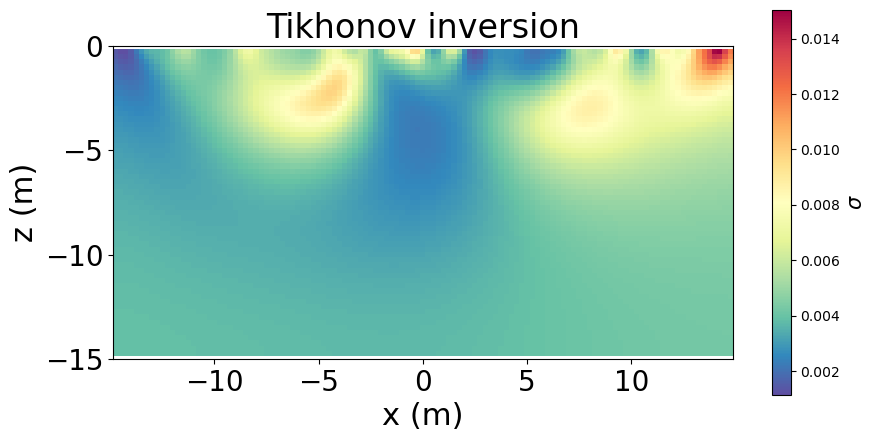

In [18]:
# Plot the recovered model
clim = [np.exp(mopt2).min(), np.exp(mopt2).max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(np.exp(mopt2), ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral_r"})
cd = plt.colorbar(dat[0])
cd.set_label(label=r'$\sigma$', size=15)
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)

/tmp/ipykernel_468400/1495826307.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(mopt - mopt2), ax=ax, pcolorOpts={'cmap':"Spectral_r"})


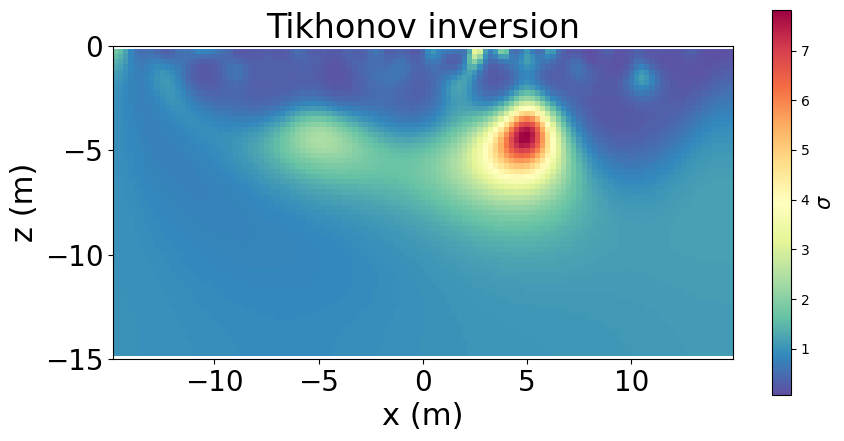

In [17]:
# Plot the recovered model
clim = [np.exp(mopt).min(), np.exp(mopt).max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(np.exp(mopt - mopt2), ax=ax, pcolorOpts={'cmap':"Spectral_r"})
cd = plt.colorbar(dat[0])
cd.set_label(label=r'$\sigma$', size=15)
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)

In [ ]:
start = time.time()
results_collect = [None] * 10
for ii in range(10):

    perturbed_data3 = np.random.multivariate_normal(simulation.survey.dobs, Wd, size=1)[0, :]
    survey_rto3 = survey
    survey_rto3.dobs = perturbed_data3
    survey_rto3.std = np.abs(perturbed_data3) * 0.02
    survey_rto3.eps = 1e-3

    simulation_rto3 = dc.Simulation2DNodal(
        mesh,
        survey_rto3,
        sigmaMap=mapping,
        storeJ=True,
        solver=Solver
    )

    data_object3 = data.Data(simulation_rto3.survey, dobs=perturbed_data3, standard_deviation=survey_rto3.std)

    #  Data misfit
    survey_rto3.eps = 1e-2
    dmis_rto3 = data_misfit.L2DataMisfit(data=data_object3, simulation=simulation_rto3)
    dmis_rto3.W = 1 / ((0.5 * simulation_rto3.survey.dobs) + survey_rto3.eps)
    # Regularization
    regmap = maps.IdentityMap(nP=int(actcore.sum()))
    # reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

    reg_rto3 = regularization.WeightedLeastSquares(
        mesh, 
        active_cells=actcore,
        mapping=regmap,
        reference_model=perturbed_mod
    )
    reg_rto3.alpha_s = 1/csx**2
    reg_rto3.alpha_x = 100
    reg_rto3.alpha_y = 100
    reg_rto3.alpha_z = 100

    # Optimization object
    opt_rto3 = optimization.ProjectedGNCG(maxIter=5, lower=-10, upper=10,
                                    maxIterLS=20, maxIterCG=100, tolCG=1e-5)

    opt_rto3.remember('xc')

    # Set the inverse problem
    invProb_rto3 = inverse_problem.BaseInvProblem(dmis_rto3,  reg_rto3,  opt_rto3)
    invProb_rto3.beta = 1e0

    # Inversion directives
    Target = directives.TargetMisfit()
    betaSched = directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
    updateSensW = directives.UpdateSensitivityWeights(threshold=1e-2,everyIter=False)
    update_Jacobi = directives.UpdatePreconditioner()
    inv_rto3 = inversion.BaseInversion(invProb_rto3,  directiveList=[ # updateSensW, 
                                                        Target,
                                                        betaSched,
                                                        #    update_Jacobi,
                                                        ])
    
    # Run the inversion
    mopt3 = inv_rto3.run(m0)
    results_collect[ii] = mopt3
print('Inversion took {0} seconds'.format(time.time() - start))

In [ ]:

# Plot the recovered model
# clim = [(1 / np.exp(mopt)).min(), (1/np.exp(mopt)).max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(results_collect[0], ax=ax, pcolorOpts={'cmap':"Spectral_r"})
cd = plt.colorbar(dat[0])
cd.set_label(label=r'$\sigma$', size=15)
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)

#### Directives

## This is the code that plots the distributions in resistivity

In [ ]:
# plot the histogram of the PGI recovered model
fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]
ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),linewidth=2,label='True petrophysical\ndistribution',c='k')
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,800])
hist, edges = np.histogram(mcluster,bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",label='PGI model Hist.',color='#d65f5f')
ax.legend(loc=0,fontsize=18)
ax.set_ylim([0.,12])
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]
ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),linewidth=2,label='True petrophysical\ndistribution',c='k')
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,800])
hist, edges = np.histogram(mopt,bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",label='Tikhonov model Hist.',color='#d65f5f')
ax.legend(loc=0,fontsize=18)
ax.set_ylim([0.,12])
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]
ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),linewidth=2,label='True petrophysical\ndistribution',c='k')
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,800])
hist, edges = np.histogram(geological_model,bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",label='Quasi Geological model Hist.',color='#d65f5f')
ax.legend(loc=0,fontsize=18)
ax.set_ylim([0.,12])
plt.show()

## Classification

## segment anything

### complex model segmentation

- Use masks as the neighborhood for gmmrf classification

$$g_i = \min_{\boldsymbol{\mu}_n} \big \| \mathbf{m}_i - \boldsymbol{\mu}_n \big \|^2$$

# creating variations on the model